In [258]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# Spaceship Titanic
A twist on the titanic dataset, a bunch of people are on the titanic spaceship going to another galaxy, when they come out of hyperspace, some are transported away and others are not. The goal is to predict who is transported, which is located in the 'transported' column of the data set.


In [259]:
#loading data
df_train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
df_sub = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')

## Preliminary Data Exploration
Now I need to explore the data. Look at the shape, check out the columns, check for missing values, think on ways to make the data more useful.

In [260]:
#check dataframe
df_train.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [261]:
df_train.shape

(8693, 14)

In [262]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


## In Depth Data Exploration

From my preliminary exploration, there are a few things to change. PassengerID and Cabin can be split into 5 total columns which will be better for communicating their information. Passenger ID into group and number and Cabin into section, room, side.

### Passenger ID

Passenger ID is a four digit number corresponding to the family/group followed by an underscore followed by a two digit number telling us person number of the group. There are zero null passenger ID columns. I will split on the underscore creating two new columns, group and person and make the assumption that home planet, cryosleep and destination are the same for all people from a single group.

### Cabin 

Will fill na values with family members, else leave blank.

Cabin consists of a letter followed by a forward slash followed by a number followed by a forward slash follwed by a letter. First corresponds to section, 3rd corresponds to port/starboard.\

Will split into three columns, section/room/side.

### Total Spend and Spent

Will create a new column with the total amount of cash spent by travelers and a categorical with True/False if they spent money or not.

## In Depth Data Exploration

Now that I have the columns I want, I will view descriptive statistics, check correlations and skew. There's a decent amount of missing data, and a lot of things that could be done to fill it in. 

The data is fairly skewed, in that there's a lot of people that aren't spending money on the services, this is probably related to cryosleep and what deck their on but I will have to look into data further. Cabin should be split into multiple columns ad the passenger ID can probably be used to determine if people are in the same family and therefore have the same home planet/destination.


In [263]:
#splitting passenger id, cabin and name
df_train[['Group','Number']] = df_train['PassengerId'].str.split('_', expand= True)
df_train[['Section', 'Room', 'Side']] = df_train['Cabin'].str.split('/', expand = True)
df_train[['FirstName','LastName']] = df_train['Name'].str.split(' ', expand = True)

#combine costs into 'services
spend_features = ['RoomService', 'FoodCourt','ShoppingMall','Spa','VRDeck']
df_train['TotalSpend'] = df_train[spend_features].sum(axis=1)
df_train['Spent'] = (df_train['TotalSpend']==0).astype(int)

In [264]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Transported,Group,Number,Section,Room,Side,FirstName,LastName,TotalSpend,Spent
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,False,0001,01,B,0,P,Maham,Ofracculy,0.0,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,True,0002,01,F,0,S,Juanna,Vines,736.0,0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,False,0003,01,A,0,S,Altark,Susent,10383.0,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,False,0003,02,A,0,S,Solam,Susent,5176.0,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,True,0004,01,F,1,S,Willy,Santantines,1091.0,0


In [265]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
 14  Group         8693 non-null   object 
 15  Number        8693 non-null   object 
 16  Section       8494 non-null   object 
 17  Room          8494 non-null   object 
 18  Side          8494 non-null 

In [266]:
df_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalSpend,Spent
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000,8693.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,1440.866329,0.420223
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,2803.045694,0.493623
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,716.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,1441.000000,1.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,35987.000000,1.000000


In [267]:
#display correlations
df_train.corr(method='pearson')

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,TotalSpend,Spent
Age,1.000000,0.068723,0.130421,0.033133,0.123970,0.101007,-0.075026,0.186530,-0.230221
RoomService,0.068723,1.000000,-0.015889,0.054480,0.010080,-0.019581,-0.244611,0.237998,-0.286793
FoodCourt,0.130421,-0.015889,1.000000,-0.014228,0.221891,0.227995,0.046566,0.745105,-0.241778
ShoppingMall,0.033133,0.054480,-0.014228,1.000000,0.013879,-0.007322,0.010141,0.222310,-0.243392
Spa,0.123970,0.010080,0.221891,0.013879,1.000000,0.153821,-0.221131,0.596633,-0.233378
VRDeck,0.101007,-0.019581,0.227995,-0.007322,0.153821,1.000000,-0.207075,0.586299,-0.226161
Transported,-0.075026,-0.244611,0.046566,0.010141,-0.221131,-0.207075,1.000000,-0.199514,0.481628
TotalSpend,0.186530,0.237998,0.745105,0.222310,0.596633,0.586299,-0.199514,1.000000,-0.437651
Spent,-0.230221,-0.286793,-0.241778,-0.243392,-0.233378,-0.226161,0.481628,-0.437651,1.000000


In [269]:
df_train.skew()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


PassengerId      0.002020
CryoSleep        0.591110
Age              0.419097
VIP              6.300900
RoomService      6.333014
FoodCourt        7.102228
ShoppingMall    12.627562
Spa              7.636020
VRDeck           7.819732
Transported     -0.014497
Group            0.002020
Number           2.746617
Room             0.718360
TotalSpend       4.417588
Spent            0.323304
dtype: float64

## Data Visualization
I'm creating some basic graphs to visualize our data. The biggest thing that jumps out at me is that cryosleep and homeplanet seem to be important for whether or not someone gets transported. I will pay particular attention to how I fill in these columns.

Another thing I notice is how a very small number of people spend a lot of money on the "perks" during the trip. It might be worth combining money spent on perks into a single column for simplicity.

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'RoomService'}>,
        <AxesSubplot:title={'center':'FoodCourt'}>],
       [<AxesSubplot:title={'center':'ShoppingMall'}>,
        <AxesSubplot:title={'center':'Spa'}>,
        <AxesSubplot:title={'center':'VRDeck'}>],
       [<AxesSubplot:title={'center':'TotalSpend'}>,
        <AxesSubplot:title={'center':'Spent'}>, <AxesSubplot:>]],
      dtype=object)

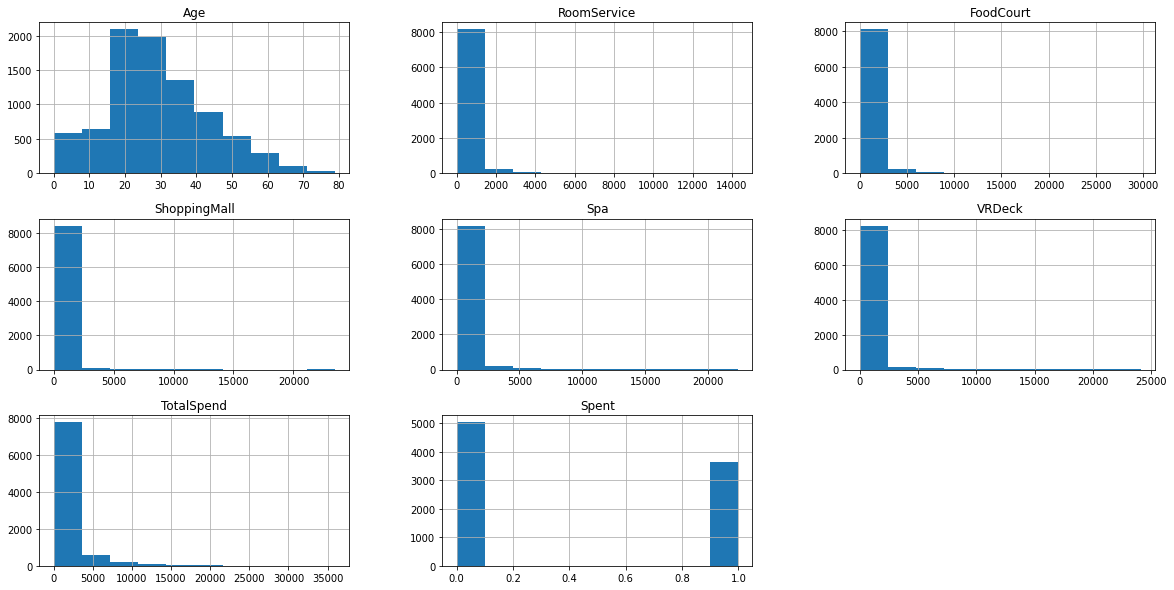

In [270]:
#histogram overview
df_train.hist(figsize = (20, 10)) 

array([[<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
        <AxesSubplot:ylabel='Density'>],
       [<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
        <AxesSubplot:ylabel='Density'>],
       [<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
        <AxesSubplot:ylabel='Density'>]], dtype=object)

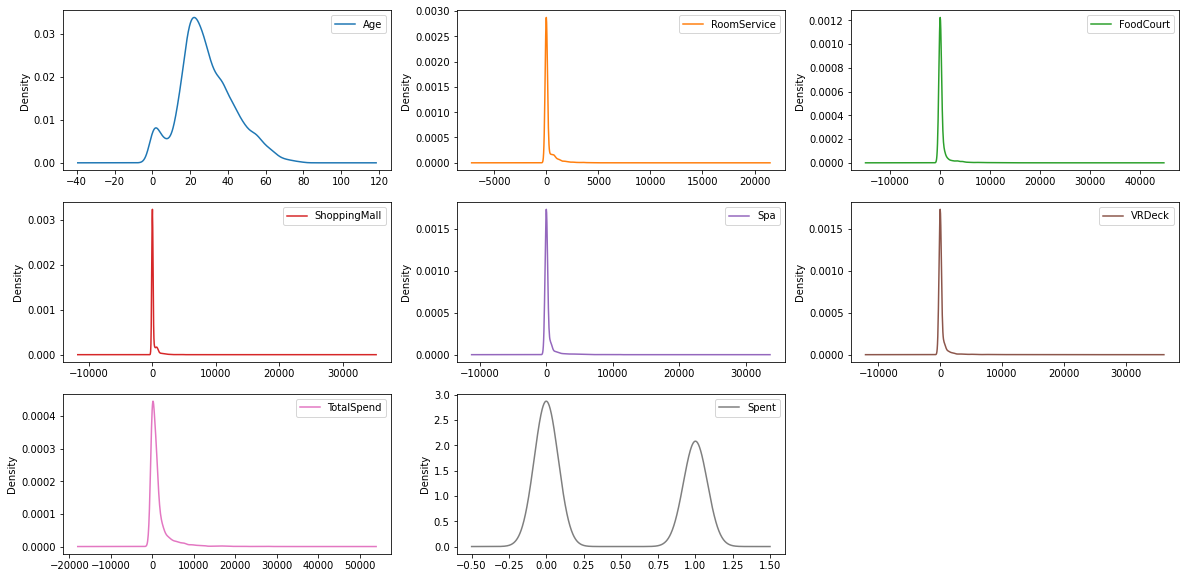

In [271]:
#density plot
df_train.plot(kind='density', figsize = (20, 10), subplots=True, layout=(3,3), sharex=False)

Age                AxesSubplot(0.125,0.657941;0.227941x0.222059)
RoomService     AxesSubplot(0.398529,0.657941;0.227941x0.222059)
FoodCourt       AxesSubplot(0.672059,0.657941;0.227941x0.222059)
ShoppingMall       AxesSubplot(0.125,0.391471;0.227941x0.222059)
Spa             AxesSubplot(0.398529,0.391471;0.227941x0.222059)
VRDeck          AxesSubplot(0.672059,0.391471;0.227941x0.222059)
TotalSpend            AxesSubplot(0.125,0.125;0.227941x0.222059)
Spent              AxesSubplot(0.398529,0.125;0.227941x0.222059)
dtype: object

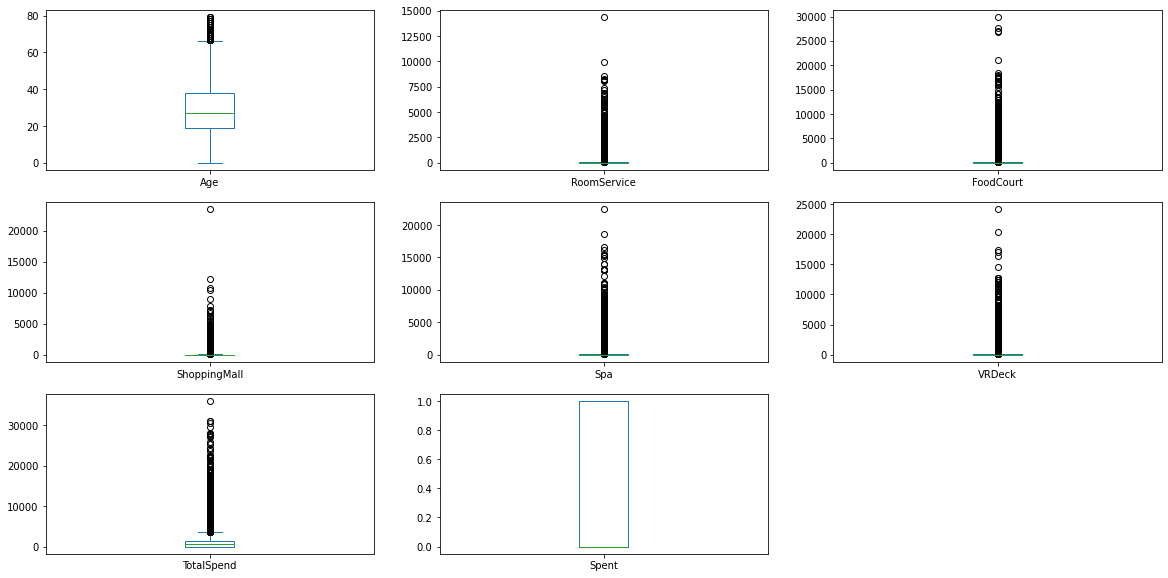

In [272]:
#box and whisker plot
df_train.plot(kind='box', subplots=True, figsize = (20, 10), layout=(3,3), sharex=False, sharey=False) 

### Countplots

These really help to visualize some of the relationships. People from Europa are more likely to be transported, people from Earth less likely, and people from mars have about an even chance. People in cryosleep are WAY more likely to be transported. The destination matters a little bit, and being a VIP doesn't matter at all.

<AxesSubplot:xlabel='HomePlanet', ylabel='count'>

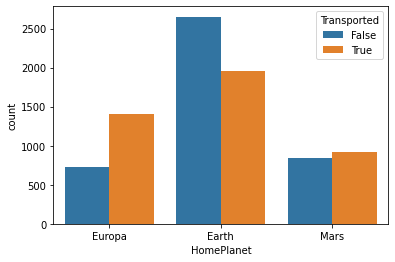

In [273]:
sns.countplot(x='HomePlanet', hue= 'Transported', data=df_train) 

<AxesSubplot:xlabel='CryoSleep', ylabel='count'>

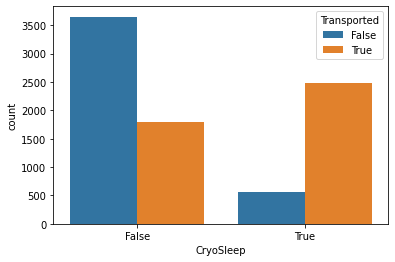

In [274]:
sns.countplot(x='CryoSleep', hue= 'Transported', data=df_train) 

<AxesSubplot:xlabel='Destination', ylabel='count'>

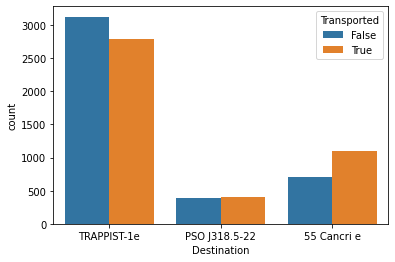

In [275]:
sns.countplot(x='Destination', hue= 'Transported', data=df_train) 

<AxesSubplot:xlabel='VIP', ylabel='count'>

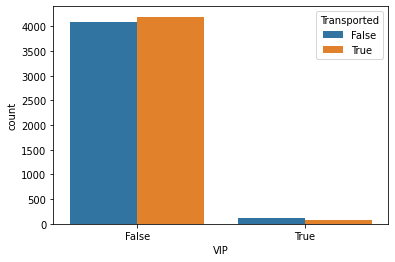

In [276]:
sns.countplot(x='VIP', hue= 'Transported', data=df_train) 

<AxesSubplot:xlabel='Section', ylabel='count'>

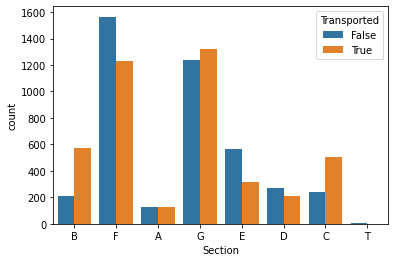

In [277]:
sns.countplot(x='Section', hue= 'Transported', data=df_train)

<AxesSubplot:xlabel='Side', ylabel='count'>

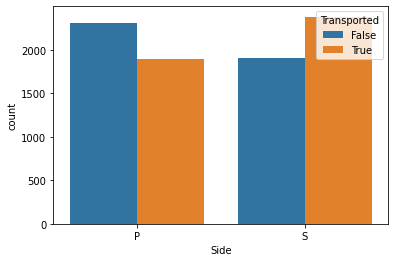

In [278]:
sns.countplot(x='Side', hue= 'Transported', data=df_train)

<AxesSubplot:xlabel='CryoSleep', ylabel='count'>

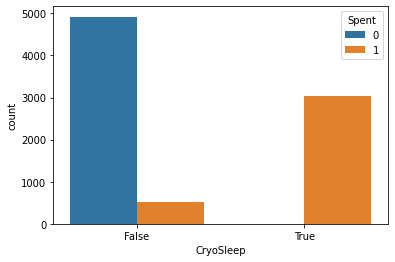

In [279]:
sns.countplot(x='CryoSleep', hue= 'Spent', data=df_train)

<AxesSubplot:xlabel='Destination', ylabel='count'>

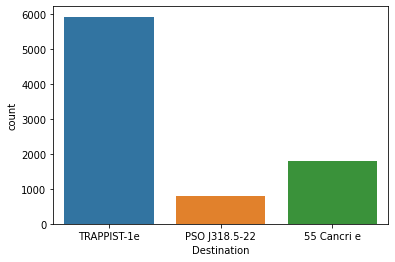

In [280]:
sns.countplot(x='Destination', data=df_train)

# Data Munging
So I can go about this a bunch of different ways. The fastest way is to drop everything that has an NA value and then run ML algorithms. Doing this takes you from 8700 to 6600 entries, 20-25% of data lost, which isn't acceptable. So lets go through the columns on by one and try filling in missing values. There's a lot of "NaN" values in both object and float datatype columns. There's also a lot of "0" values in spending for various services, I'll have to decide if I treat that as a NA value or if 0 is the correct value.

I'm going to give a little overview of each column and tell what my plans are for it:

## Old Columns
List of original columns.

### Passenger ID
Zero null values.

This was split, will be ignored and dropped prior to ML algorithm implementation.

### Cabin
~200 null values. 

This was split, will be ignored and dropped prior to ML algorithm implementation.

### Home Planet
~200 null values.

One of three home planets

Will fill in full values first with group id, then last name, then with cabin. Any remaining will be filled in with mode.

### Cryosleep
~200 null values.

The most important factor determining if someone was sent or not. Important to get this as accurate as possible. Will look for patterns, particularly with spending and cryosleep.

### Destination
~200 null values. Seems to have a fairly small relation to whether or not someone got transported. Will fill in similarly to home planet.

### Age
~200 null values.
Will fill in with mode.

### VIP
~200 null values
Will fill in with mode.

### Name
~200 null values
This was split, will be ignored and dropped prior to ML algorithm implementation.

## New Columns

### Total Spend
Combination of all expenses.

### Spent
Boolean reflecting whether or not someone spent money.

### Section
~200 null values, matters with regards to transportation.

### Room
~200 null values, dropping this column.

### Side
~200 null values, matters with regards to transportation.

### Last Name
~200 null values, using to help fill in other columns, will end up dropping this column.


In [281]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Transported,Group,Number,Section,Room,Side,FirstName,LastName,TotalSpend,Spent
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,False,0001,01,B,0,P,Maham,Ofracculy,0.0,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,True,0002,01,F,0,S,Juanna,Vines,736.0,0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,False,0003,01,A,0,S,Altark,Susent,10383.0,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,False,0003,02,A,0,S,Solam,Susent,5176.0,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,True,0004,01,F,1,S,Willy,Santantines,1091.0,0


In [223]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
 14  Group         8693 non-null   object 
 15  Number        8693 non-null   object 
 16  Section       8494 non-null   object 
 17  Room          8494 non-null   object 
 18  Side          8494 non-null 

# Home Planet NA values
We want to fill in the home planet NA values by using other columns to accurately fill the values and if there are any left over at the end use mode. Our strategy is going to be first use the group which we craeted from passenger ID, then last name, then cabin and then the mode.

## Using Group to fill in Home Planet
We need to check if all people from a single group came from the same home planet. I will groupby 'group' and 'homeplanet' and count by home planet, unstack the columns and fill in any nan values with 0, then check the dataframe I created.


In [282]:
#create home planet dataframe
df_homeplanet = df_train.groupby(['Group', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
df_homeplanet.head()

HomePlanet,Earth,Europa,Mars
Group,,,
0001,0.0,1.0,0.0
0002,1.0,0.0,0.0
0003,0.0,2.0,0.0
0004,1.0,0.0,0.0
0005,1.0,0.0,0.0


## Using Group to fill in Home Planet Continued...
Turning values to boolean and back to integer and adding them in a final columns and checking how many unique values there are in the sum column will show me whether or not there are groups with multiple home planets, there are not.

In [283]:
#converting into boolean and back to int, adding together and checking what unique values there are with the sum to see if there are 
#any cases where people from different groups have different home planets, there are not
df_homeplanet['Earth'] = df_homeplanet['Earth'].astype('bool')
df_homeplanet['Earth'] = df_homeplanet['Earth'].astype('int64')
df_homeplanet['Europa'] = df_homeplanet['Europa'].astype('bool')
df_homeplanet['Europa'] = df_homeplanet['Europa'].astype('int64')
df_homeplanet['Mars'] = df_homeplanet['Mars'].astype('bool')
df_homeplanet['Mars'] = df_homeplanet['Mars'].astype('int64')

df_homeplanet['total'] = df_homeplanet['Earth']+df_homeplanet['Europa']+df_homeplanet['Mars']
df_homeplanet['total'].unique()


array([1])

In [284]:
#how many 
planet_before = df_train['HomePlanet'].isna().sum()
print(planet_before)

201


In [285]:
#creating a list of index values where home planet is na but the group isn't and changing the home planet value to what the rest of the goroup has
homeplanet_index=df_train[df_train['HomePlanet'].isna()][(df_train[df_train['HomePlanet'].isna()]['Group']).isin(df_homeplanet.index)].index
df_train.loc[homeplanet_index,'HomePlanet']=df_train.iloc[homeplanet_index,:]['Group'].map(lambda x: df_homeplanet.idxmax(axis=1)[x])

In [286]:
df_train['HomePlanet'].isna().sum()

111

## Using last name to fill homeplanet

I'm doing the same as I did with group but with last name. Verify they all work this way, then implement.

In [229]:
#do the same but for last name
df_homeplanet = df_train.groupby(['LastName', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
df_homeplanet.head()

HomePlanet,Earth,Europa,Mars
LastName,,,
Acobson,4.0,0.0,0.0
Acobsond,3.0,0.0,0.0
Adavisons,9.0,0.0,0.0
Adkinson,3.0,0.0,0.0
Admingried,0.0,4.0,0.0


In [287]:
df_homeplanet['Earth'] = df_homeplanet['Earth'].astype('bool')
df_homeplanet['Earth'] = df_homeplanet['Earth'].astype('int64')
df_homeplanet['Europa'] = df_homeplanet['Europa'].astype('bool')
df_homeplanet['Europa'] = df_homeplanet['Europa'].astype('int64')
df_homeplanet['Mars'] = df_homeplanet['Mars'].astype('bool')
df_homeplanet['Mars'] = df_homeplanet['Mars'].astype('int64')

df_homeplanet['total'] = df_homeplanet['Earth']+df_homeplanet['Europa']+df_homeplanet['Mars']
df_homeplanet['total'].unique()

array([1])

In [288]:
homeplanet_index=df_train[df_train['HomePlanet'].isna()][(df_train[df_train['HomePlanet'].isna()]['LastName']).isin(df_homeplanet.index)].index
df_train.loc[homeplanet_index,'HomePlanet']=df_train.iloc[homeplanet_index,:]['LastName'].map(lambda x: df_homeplanet.idxmax(axis=1)[x])

In [232]:
df_train['HomePlanet'].isna().sum()

12

## Using Section to fill homeplanet

I got it from >200 NAN values to 12! I'm going to try closing it out with section and then go to mode. Section is messier, I have to make some assumptions...

Also for mode I will be doing is a group later with categoricals.

<AxesSubplot:xlabel='Section', ylabel='count'>

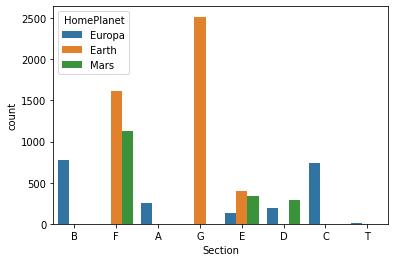

In [289]:
#home planet exploration
import seaborn as sns
sns.countplot(x='Section', hue= 'HomePlanet', data=df_train)
#Europa - B, A, C, T
#Earth - G
#unknown - F, E, D

In [290]:
df_train.loc[(df_train['HomePlanet'].isna()) & (df_train['Section'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet'] = 'Europa'
df_train.loc[(df_train['HomePlanet'].isna()) & (df_train['Section'].isin(['G'])), 'HomePlanet'] = 'Earth'

In [291]:
df_train['HomePlanet'].isna().sum()

63

<AxesSubplot:xlabel='HomePlanet', ylabel='count'>

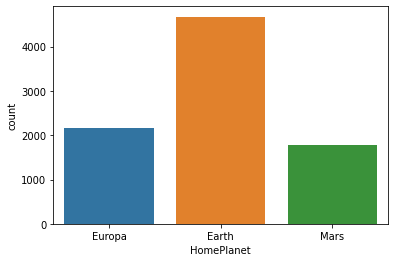

In [292]:
sns.countplot(x='HomePlanet', data=df_train)

In [293]:
df_train.loc[(df_train['HomePlanet'].isna()), 'HomePlanet']='Earth'

# CryoSleep

Cryosleep is very important. It seems to be the single most important factor for determining whether or not someone is transported. My gut tells me that the easiest way to tell if someone was in cryosleep is whether or not they spent any money on entertainment. 


In [294]:
df_train.groupby(['Spent', 'CryoSleep'])['CryoSleep'].size().unstack().fillna(0)

CryoSleep,False,True
Spent,,
0,4921.0,0.0
1,518.0,3037.0


In [295]:
df_train['CryoSleep'].isna().sum()

217

In [296]:
csleep=df_train.loc[df_train['CryoSleep'].isna(),'CryoSleep'].index
df_train.loc[df_train['CryoSleep'].isna(),'CryoSleep']=df_train.groupby(['Spent'])['CryoSleep'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[csleep]

In [297]:
df_train['CryoSleep'].isna().sum()

0

## Destination

Going to use the same strategy I used with Home Planet.

In [298]:
#create home planet dataframe
df_destination = df_train.groupby(['Group', 'Destination'])['Destination'].size().unstack().fillna(0)
df_destination.head()

Destination,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
Group,,,
0001,0.0,0.0,1.0
0002,0.0,0.0,1.0
0003,0.0,0.0,2.0
0004,0.0,0.0,1.0
0005,0.0,1.0,0.0


In [299]:
#converting into boolean and back to int, adding together and checking what unique values there are with the sum to see if there are 
#any cases where people from different groups have different home planets, there are not
df_destination['55 Cancri e'] = df_destination['55 Cancri e'].astype('bool')
df_destination['55 Cancri e'] = df_destination['55 Cancri e'].astype('int64')
df_destination['PSO J318.5-22'] = df_destination['PSO J318.5-22'].astype('bool')
df_destination['PSO J318.5-22'] = df_destination['PSO J318.5-22'].astype('int64')
df_destination['TRAPPIST-1e'] = df_destination['TRAPPIST-1e'].astype('bool')
df_destination['TRAPPIST-1e'] = df_destination['TRAPPIST-1e'].astype('int64')

df_destination['total'] = df_destination['TRAPPIST-1e']+df_destination['PSO J318.5-22']+df_destination['55 Cancri e']
df_destination['total'].unique()

array([1, 2, 3])

<AxesSubplot:xlabel='Destination', ylabel='count'>

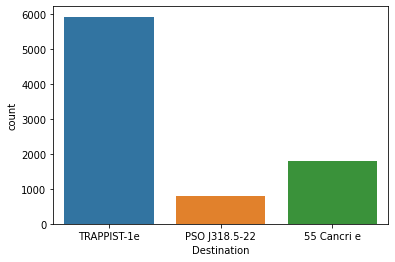

In [300]:
sns.countplot(x='Destination', data=df_train)

## Destination Continued

It doesn't look like I can make the same assumptions about destination that I made about home planet. The vast majority of people are going to trappist, so that's what I will assign NA values as.

In [301]:
df_train.loc[(df_train['Destination'].isna()), 'Destination']='TRAPPIST-1e'

In [302]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8693 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8693 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
 14  Group         8693 non-null   object 
 15  Number        8693 non-null   object 
 16  Section       8494 non-null   object 
 17  Room          8494 non-null   object 
 18  Side          8494 non-null 

## Section/Side

Leaving a mark here to come back later and do some additional work for section/side. Right now, I'm just going to follow my medians for continuous and modes for categorical data. 

In [303]:
#drop columns I don't care about
df_train.drop(['PassengerId','Cabin','Name', 'Group','Number','Room','FirstName','LastName'],axis=1,inplace=True) 
#drop dollar columns but spend/spent
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   object 
 1   CryoSleep     8693 non-null   object 
 2   Destination   8693 non-null   object 
 3   Age           8514 non-null   float64
 4   VIP           8490 non-null   object 
 5   RoomService   8512 non-null   float64
 6   FoodCourt     8510 non-null   float64
 7   ShoppingMall  8485 non-null   float64
 8   Spa           8510 non-null   float64
 9   VRDeck        8505 non-null   float64
 10  Transported   8693 non-null   bool   
 11  Section       8494 non-null   object 
 12  Side          8494 non-null   object 
 13  TotalSpend    8693 non-null   float64
 14  Spent         8693 non-null   int64  
dtypes: bool(1), float64(7), int64(1), object(6)
memory usage: 959.4+ KB


In [307]:
#replace na's with most common for categoricals
categoricals = ['HomePlanet','CryoSleep','Destination','VIP','Section','Side','Spent']
numerics = ['TotalSpend','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Age']
for i in categoricals:
    df_train[i].fillna(df_train[i].mode()[0], inplace=True)
    
for i in numerics:
    df_train[i].fillna(df_train[i].median(), inplace=True)

In [305]:
df_train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Section,Side,TotalSpend,Spent
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,P,0.0,1
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,S,736.0,0
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,S,10383.0,0
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,S,5176.0,0
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,S,1091.0,0


In [250]:
df_train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Section,Side,TotalSpend,Spent
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,P,0.0,1
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,S,736.0,0
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,S,10383.0,0
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,S,5176.0,0
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,S,1091.0,0


In [308]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   object 
 1   CryoSleep     8693 non-null   bool   
 2   Destination   8693 non-null   object 
 3   Age           8693 non-null   float64
 4   VIP           8693 non-null   bool   
 5   RoomService   8693 non-null   float64
 6   FoodCourt     8693 non-null   float64
 7   ShoppingMall  8693 non-null   float64
 8   Spa           8693 non-null   float64
 9   VRDeck        8693 non-null   float64
 10  Transported   8693 non-null   bool   
 11  Section       8693 non-null   object 
 12  Side          8693 non-null   object 
 13  TotalSpend    8693 non-null   float64
 14  Spent         8693 non-null   int64  
dtypes: bool(3), float64(7), int64(1), object(4)
memory usage: 840.6+ KB


## Data Munging -  Replacing categoricals with numbers

In [309]:
df_train['HomePlanet'].replace(['Earth','Europa', 'Mars'],[0,1,2],inplace=True)
df_train['CryoSleep'].replace(['False','True'],[0,1],inplace=True)
df_train['Destination'].replace(['TRAPPIST-1e','55 Cancri e','PSO J318.5-22'],[0,1,2],inplace=True)
df_train['Section'].replace(['F','G', 'E', 'B', 'C', 'D', 'A', 'T'],[0,1, 2, 3, 4, 5, 6, 7],inplace=True)
df_train['Side'].replace(['S','P'],[0,1],inplace=True)
df_train['VIP'].replace(['False','True'], [0,1], inplace=True)

In [253]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   int64  
 1   CryoSleep     8693 non-null   bool   
 2   Destination   8693 non-null   int64  
 3   Age           8514 non-null   float64
 4   VIP           8693 non-null   bool   
 5   RoomService   8693 non-null   float64
 6   FoodCourt     8693 non-null   float64
 7   ShoppingMall  8693 non-null   float64
 8   Spa           8693 non-null   float64
 9   VRDeck        8693 non-null   float64
 10  Transported   8693 non-null   bool   
 11  Section       8693 non-null   int64  
 12  Side          8693 non-null   int64  
 13  TotalSpend    8693 non-null   float64
 14  Spent         8693 non-null   int64  
dtypes: bool(3), float64(7), int64(5)
memory usage: 840.6 KB


# Data Transformation
The skew on the spending columns is terrible, I could try a logarithmic transform to increase data normality.

In [ ]:
#df_train['TotalSpend'] = np.log(1+df_train['TotalSpend'])

# Machine Learning
I will be running the data through several algorithms, using cross validation to score the data, then choosing a couple of the higher performing algorithms to run hyperparameterization on. 


In [310]:
X = df_train.drop(columns = 'Transported')
y = df_train['Transported']

In [311]:
X.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Section,Side,TotalSpend,Spent
0,1,False,0,39.0,False,0.0,0.0,0.0,0.0,0.0,3,1,0.0,1
1,0,False,0,24.0,False,109.0,9.0,25.0,549.0,44.0,0,0,736.0,0
2,1,False,0,58.0,True,43.0,3576.0,0.0,6715.0,49.0,6,0,10383.0,0
3,1,False,0,33.0,False,0.0,1283.0,371.0,3329.0,193.0,6,0,5176.0,0
4,0,False,0,16.0,False,303.0,70.0,151.0,565.0,2.0,0,0,1091.0,0


## Machine Learning - Model Choice
We tried out three models, the gradient boosting classifier worked the best. Now I want to iterate through important hyper parameters of the model of choice to see if I can improve on it. The parameters to iterate through are particular to each type of model,I chose learning rate, n estimators and max leaf nodes based off of the documentation. These should get me most of the way there.

In [312]:
#create lists for relevant model metrics, this will be used to compare different models
model = []
model_mean = []
model_std = []

#k-fold cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
X = X
y = y

#folds, adjust based on # of data points
folds = 10
kfold = KFold(n_splits = folds, random_state = 1, shuffle=True)

In [257]:
X.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Section,Side,TotalSpend,Spent
0,1,False,0,39.0,False,0.0,0.0,0.0,0.0,0.0,3,1,0.0,1
1,0,False,0,24.0,False,109.0,9.0,25.0,549.0,44.0,0,0,736.0,0
2,1,False,0,58.0,True,43.0,3576.0,0.0,6715.0,49.0,6,0,10383.0,0
3,1,False,0,33.0,False,0.0,1283.0,371.0,3329.0,193.0,6,0,5176.0,0
4,0,False,0,16.0,False,303.0,70.0,151.0,565.0,2.0,0,0,1091.0,0


In [313]:
#decision tree classifier
from sklearn.tree import DecisionTreeClassifier
method = DecisionTreeClassifier(random_state = 1) 
results = cross_val_score(method, X, y, cv=kfold)
model.append(method)
model_mean.append(round(results.mean(), 4))
model_std.append(round(results.std(), 4))


In [314]:
#random forest classifier
from sklearn.ensemble import RandomForestClassifier
method = RandomForestClassifier(random_state=1) 
results = cross_val_score(method, X, y, cv=kfold)
model.append(method)
model_mean.append(round(results.mean(), 4))
model_std.append(round(results.std(), 4))


In [315]:
#gradient boosting classifier
from sklearn.ensemble import GradientBoostingClassifier
method = GradientBoostingClassifier(random_state=1) 
results = cross_val_score(method, X, y, cv=kfold)
model.append(method)
model_mean.append(round(results.mean(), 4))
model_std.append(round(results.std(), 4))


In [316]:
#xgboost
from xgboost import XGBClassifier
method = XGBClassifier(random_state=1)
results = cross_val_score(method, X, y, cv=kfold)
model.append(method)
model_mean.append(round(results.mean(), 4))
model_std.append(round(results.std(), 4))

In [319]:
#knn
from sklearn.neighbors import KNeighborsClassifier
method = KNeighborsClassifier()
results = cross_val_score(method, X, y, cv=kfold)

#adding to end of list of model metrics
model.append(method)
model_mean.append(round(results.mean(), 4))
model_std.append(round(results.std(), 4))

In [320]:
#model table
models = pd.DataFrame({
    'Model' : model,
    'Score' : model_mean,
    'std' : model_std
})


models.sort_values(by = 'Score', ascending = False)

,Model,Score,std
3,"XGBClassifier(base_score=None, booster=None, c...",0.7998,0.0056
2,GradientBoostingClassifier(random_state=1),0.7991,0.0070
1,RandomForestClassifier(random_state=1),0.7884,0.0088
4,KNeighborsClassifier(),0.7707,0.0129
0,DecisionTreeClassifier(random_state=1),0.7382,0.0148


## Model Selection/Machine Learning Hyperparameterization

XGBC is the best, followed very closely by GBC and random forest. I would love to get my score above 0.80, that's the job of the next section, hyperparameter tuning.

The hyperparameter tuning takes a long time to iterate through.

The best parameters are leanint rate of 0.1, n estimators of 100, max leaf nodes of 5. But, it only barely improved the predictivity of the model. 

In [ ]:
'''
from sklearn.ensemble import GradientBoostingClassifier
best_score = 0


for learning_rate in [0.1, 1, 10, 100]:
    for n_estimators in [50, 100, 500, 1000]:
        for max_leaf_nodes in [2, 4, 5]:
            gbc = GradientBoostingClassifier(random_state=1, learning_rate=learning_rate, n_estimators=n_estimators, max_leaf_nodes=max_leaf_nodes)
            scores = cross_val_score(gbc, X, y, cv = 5)
            score = np.mean(scores)
            if score > best_score:
                best_score = score
                best_std = np.std(scores)
                best_parameters = {'learning rate':learning_rate, 'n estimators':n_estimators, 'max leaf nodes': max_leaf_nodes}
                
                
print(best_score)
print(best_std)
print(best_parameters)
'''

In [ ]:
'''
from xgboost import XGBClassifier
best_score = 0


for learning_rate in [0.01, 0.1, 0.5, 1, 10]:
    for n_estimators in [25, 100, 500, 1000]:
        for max_depth in [2, 3, 4, 5, 6]:
            xgb = XGBClassifier(random_state=1, learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth)
            scores = cross_val_score(xgb, X, y, cv = 5)
            score = np.mean(scores)
            if score > best_score:
                best_score = score
                best_std = np.std(scores)
                best_parameters = {'learning rate':learning_rate, 'n estimators':n_estimators, 'max depth': max_depth}
                
                
print(best_score)
print(best_std)
print(best_parameters)
'''

## Machine Learning - Build Final Model
Enter in the parameter values for XGBC and train the model.

In [321]:
#gbc = GradientBoostingClassifier(random_state=1, learning_rate=0.1, n_estimators = 500, max_leaf_nodes = 5)
#gbc.fit(X, y)
xgbc = XGBClassifier(random_state=1, learning_rate=0.1, n_estimators=100, max_depth=6)
xgbc.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)

## Applying Changes to Test Data

Apply all the changes to the test data that I worked through with the training data above.

In [322]:
#split cabin into 3 columns, there are 3 types of data contained in this

#splitting passenger id, cabin and name
df_test[['Group','Number']] = df_test['PassengerId'].str.split('_', expand= True)
df_test[['Section', 'Room', 'Side']] = df_test['Cabin'].str.split('/', expand = True)
df_test[['FirstName','LastName']] = df_test['Name'].str.split(' ', expand = True)

#combine costs into 'services

df_test['TotalSpend'] = df_test[spend_features].sum(axis=1)
df_test['Spent'] = (df_test['TotalSpend']==0).astype(int)

#homeplanet
df_homeplanet = df_test.groupby(['Group', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
homeplanet_index=df_test[df_test['HomePlanet'].isna()][(df_test[df_test['HomePlanet'].isna()]['Group']).isin(df_homeplanet.index)].index
df_test.loc[homeplanet_index,'HomePlanet']=df_test.iloc[homeplanet_index,:]['Group'].map(lambda x: df_homeplanet.idxmax(axis=1)[x])

df_homeplanet = df_test.groupby(['LastName', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
homeplanet_index=df_test[df_test['HomePlanet'].isna()][(df_test[df_test['HomePlanet'].isna()]['LastName']).isin(df_homeplanet.index)].index
df_test.loc[homeplanet_index,'HomePlanet']=df_test.iloc[homeplanet_index,:]['LastName'].map(lambda x: df_homeplanet.idxmax(axis=1)[x])

df_test.loc[(df_test['HomePlanet'].isna()) & (df_test['Section'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet'] = 'Europa'
df_test.loc[(df_test['HomePlanet'].isna()) & (df_test['Section'].isin(['G'])), 'HomePlanet'] = 'Earth'

#cryosleep
csleep=df_test.loc[df_test['CryoSleep'].isna(),'CryoSleep'].index
df_test.loc[df_test['CryoSleep'].isna(),'CryoSleep']=df_test.groupby(['Spent'])['CryoSleep'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[csleep]

#categoricals
categoricals = ['HomePlanet','CryoSleep','Destination','VIP','Section','Side','Spent']
numerics = ['TotalSpend','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Age']

df_test.drop(['PassengerId','Cabin','Name', 'Group','Number','Room','FirstName','LastName'],axis=1,inplace=True)

for i in categoricals:
    df_test[i].fillna(df_test[i].mode()[0], inplace=True)
    
for i in numerics:
    df_test[i].fillna(df_test[i].median(), inplace=True)

df_test['HomePlanet'].replace(['Earth','Europa', 'Mars'],[0,1,2],inplace=True)
df_test['CryoSleep'].replace(['False','True'],[0,1],inplace=True)
df_test['Destination'].replace(['TRAPPIST-1e','55 Cancri e','PSO J318.5-22'],[0,1,2],inplace=True)
df_test['Section'].replace(['F','G', 'E', 'B', 'C', 'D', 'A', 'T'],[0,1, 2, 3, 4, 5, 6, 7],inplace=True)
df_test['Side'].replace(['S','P'],[0,1],inplace=True)
df_test['VIP'].replace(['False','True'], [0,1], inplace=True)


In [323]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    4277 non-null   int64  
 1   CryoSleep     4277 non-null   bool   
 2   Destination   4277 non-null   int64  
 3   Age           4277 non-null   float64
 4   VIP           4277 non-null   bool   
 5   RoomService   4277 non-null   float64
 6   FoodCourt     4277 non-null   float64
 7   ShoppingMall  4277 non-null   float64
 8   Spa           4277 non-null   float64
 9   VRDeck        4277 non-null   float64
 10  Section       4277 non-null   int64  
 11  Side          4277 non-null   int64  
 12  TotalSpend    4277 non-null   float64
 13  Spent         4277 non-null   int64  
dtypes: bool(2), float64(7), int64(5)
memory usage: 409.4 KB


In [324]:
df_test.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Section,Side,TotalSpend,Spent
0,0,True,0,27.0,False,0.0,0.0,0.0,0.0,0.0,1,0,0.0,1
1,0,False,0,19.0,False,0.0,9.0,0.0,2823.0,0.0,0,0,2832.0,0
2,1,True,1,31.0,False,0.0,0.0,0.0,0.0,0.0,4,0,0.0,1
3,1,False,0,38.0,False,0.0,6652.0,0.0,181.0,585.0,4,0,7418.0,0
4,0,False,0,20.0,False,10.0,0.0,635.0,0.0,0.0,0,0,645.0,0


In [325]:
results = xgbc.predict(df_test)
results = results.astype(bool)
ids=df_sub['PassengerId']

In [326]:
final_df=pd.DataFrame({'Passengerid':ids,'Transported':results})
final_df.head(10)
#final_df.to_csv('submission.csv',index=False)

# Conclusion

This is a decent start. I would like to add a logarithmic transform to the spending categories, do some principle component analysis and do hyperparameter tuning on some of the other models to see if I couldn't coax a better result. Maybe in the future.